In [ ]:
!pip install --upgrade numpy pandas tqdm scipy matplotlib networkx seaborn statsmodels

In [20]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ks_2samp, wasserstein_distance

import warnings
warnings.filterwarnings("ignore")

In [122]:
base_dir = './'
data_dir = os.path.join(base_dir, "data")
misc_dir = os.path.join(base_dir, "misc")

In [ ]:
def deseasonalize_and_detrend(ts):
    result = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')
    return ts - result.trend - result.seasonal

In [97]:
bv = pd.read_csv(os.path.join(data_dir, 'bvisuals.csv'), 
                        parse_dates=True, index_col=0, sep=';')
mt = pd.read_csv(os.path.join(data_dir, 'mempool.csv'), 
                        parse_dates=True, index_col=0, sep=';')
mt.drop('capacity', axis=1, inplace=True)
fs = pd.read_csv(os.path.join(data_dir, 'shapes.csv'), parse_dates=True, index_col=1)\
        .rename(columns={'edges': 'channels'}).fillna(0)
fs.drop(['file_name', 'timestamp'], axis=1, inplace=True)

fs = fs.asfreq('D').interpolate().resample('1W').mean().astype(int) #method='pchip'
mt = mt.asfreq('D').interpolate().resample('1W').mean().astype(int)
bv = bv.asfreq('D').interpolate().resample('1W').mean().astype(int)
df = pd.merge(fs.reset_index(), mt.reset_index(), 
              how='left', on='datetime',
              suffixes=('_fs', '_mt'))
df = pd.merge(df, bv.reset_index()\
              .rename(columns={'nodes' : 'nodes_bv',
                               'channels' : 'channels_bv'}), 
              how='left', on='datetime')
df = df.set_index('datetime').asfreq('1W')
for c in df.columns:
    df[f"{c}_"] = deseasonalize_and_detrend(df[c])
df

,nodes_fs,channels_fs,nodes_mt,channels_mt,nodes_bv,channels_bv,nodes_fs_,channels_fs_,nodes_mt_,channels_mt_,nodes_bv_,channels_bv_
datetime,,,,,,,,,,,,
2019-01-20,1137,3240,1409,4966,2621,19763,598.141670,5579.730161,-791.076390,-9239.671207,-31.052208,940.608723
2019-01-27,1191,3606,2694,19399,2958,21676,244.392093,2658.041178,345.326364,3771.149132,120.131478,851.489443
2019-02-03,1198,3604,2660,19055,2906,22641,-246.429940,-1506.005432,130.462381,1891.114599,-33.148395,8.234782
2019-02-10,1652,6561,2686,18456,3040,23797,-102.841323,-800.465908,-86.437356,-514.530024,-28.380876,-525.182949
2019-02-17,2156,9858,2753,17836,3251,25939,8.629170,-878.257339,-71.101390,-1518.171207,3.397792,-496.728777
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-18,15135,63249,15258,68622,18074,75148,379.820060,1124.994568,53.712381,-264.010401,7.101605,-136.390218
2023-06-25,14586,61857,15422,69092,18054,75090,177.158677,449.659092,129.812644,211.719976,14.744124,18.567051
2023-07-02,13518,58941,15277,68611,18054,75090,-623.120830,-1882.757339,31.273610,339.203793,-10.352208,-84.353777


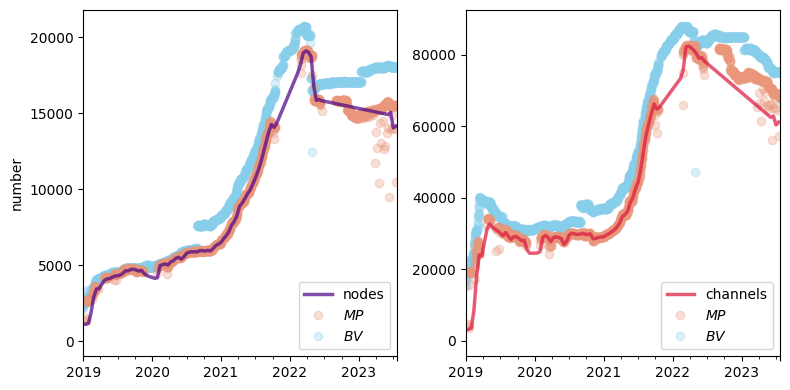

In [121]:
def fig1(file_name='fig1.png', show_figure=False, dpi=1200):
    bv = pd.read_csv(os.path.join(data_dir, 'bvisuals.csv'), 
                        parse_dates=True, index_col=0, sep=';')
    mt = pd.read_csv(os.path.join(data_dir, 'mempool.csv'), 
                        parse_dates=True, index_col=0, sep=';')
    mt.drop('capacity', axis=1, inplace=True)
    mt = mt[(mt['nodes'] > 1300)]
    fs = pd.read_csv(os.path.join(data_dir, 'shapes.csv'), parse_dates=True, index_col=1)\
        .rename(columns={'edges': 'channels'}).fillna(0)
    fs.drop(['file_name', 'timestamp'], axis=1, inplace=True)
    fs = fs.asfreq('D').interpolate().resample('2W').mean().astype(int)
    fig = plt.figure(figsize=(8, 4))
    
    ax = fig.add_subplot(1, 2, 1)
    fs[['nodes']].rename(columns={'nodes': '_A'})\
                        .plot(ax=ax, linewidth=0.001)
    bv[['nodes']].rename(columns={'nodes': '$BV$'})\
        .plot(ax=ax, style='o', lw=0.3, color='skyblue', alpha=0.3)
    mt[['nodes']].rename(columns={'nodes': '$MP$'})\
        .plot(ax=ax, style='o', lw=0.3, color='darksalmon', alpha=0.3)
    fs[['nodes']].plot(ax=ax, linewidth=2.5, color='indigo', 
            alpha=0.7)
    
    ax.set_xlim(left=datetime(2019, 1, 1), right=datetime(2023, 7, 23))
    ax.set_ylabel('number')
    ax.set_xlabel(None)

    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), 
                                reverse=True,
                                key=lambda t: t[0]))
    ax.legend(handles[:4], labels[:4], loc='lower right')

    ax = fig.add_subplot(1, 2, 2)
    fs[['channels']].rename(columns={'channels': '_A'})\
                        .plot(ax=ax, linewidth=0.001)
    bv[['channels']].rename(columns={'channels': '$BV$'})\
        .plot(ax=ax, style='o', lw=0.3, color='skyblue', alpha=0.3)
    mt[['channels']].rename(columns={'channels': '$MP$'})\
        .plot(ax=ax, style='o', lw=0.3, color='darksalmon', alpha=0.3)
    fs[['channels']].plot(ax=ax, linewidth=2.5, color='crimson', 
            alpha=0.7)

    ax.set_xlim(left=datetime(2019, 1, 1), right=datetime(2023, 7, 23))
    #ax.set_ylabel('number')
    ax.set_xlabel(None)

    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), 
                                reverse=True,
                                key=lambda t: t[0]))
    ax.legend(handles[:4], labels[:4], loc='lower right')

    fig.tight_layout()
    #fig.savefig(os.path.join(data_dir, file_name), dpi=dpi, bbox_inches='tight')
    if show_figure:
        plt.show()
fig1()

In [73]:
ks_stat, ks_p = ks_2samp(df.nodes_fs, df.nodes_bv)
print(f"\nKolmogorov-Smirnov Test: stat={ks_stat:.4f}, p={ks_p:.4f}")



Kolmogorov-Smirnov Test: stat=0.3319, p=0.0000


In [ ]:
# === STEP 3: Compare Distributions === #
# Kolmogorov-Smirnov Test
ks_stat, ks_p = ks_2samp(ts1_clean, ts2_clean)
print(f"\nKolmogorov-Smirnov Test: stat={ks_stat:.4f}, p={ks_p:.4f}")

# Wasserstein Distance (Earth Mover's Distance)
wd = wasserstein_distance(ts1_clean, ts2_clean)
print(f"Wasserstein Distance: {wd:.4f}")

# no detrend
# Kolmogorov-Smirnov Test
ks_stat, ks_p = ks_2samp(ts1, ts2)
print(f"\nKolmogorov-Smirnov Test: stat={ks_stat:.4f}, p={ks_p:.4f}")

# Wasserstein Distance (Earth Mover's Distance)
wd = wasserstein_distance(ts1, ts2)
print(f"Wasserstein Distance: {wd:.4f}")

# Optional: Plot the distributions
plt.figure(figsize=(10,5))
ts1.plot(kind='kde', label='ts1')
ts2.plot(kind='kde', label='ts2')

plt.legend()
plt.title('KDE of Cleaned Time Series')
plt.show()

plt.figure(figsize=(10,5))

ts1_clean.plot(kind='kde', label='ts1_clean')
ts2_clean.plot(kind='kde', label='ts2_clean')
plt.legend()
plt.title('KDE of Cleaned Time Series')
plt.show()

In [40]:
df

,nodes_fs,channels_fs,nodes_mt,channels_mt,nodes,channels,nodes_fs_,channels_fs_,nodes_mt_,channels_mt_,nodes_,channels_
datetime,,,,,,,,,,,,
2019-01-20,1137,3240,1409,4966,2621,19763,-1656.886592,-17834.677900,-1424.874328,-16886.279567,-726.297798,-11297.836317
2019-01-27,1192,3623,2694,19399,2958,21676,-1604.650426,-16946.175579,-407.646269,-4599.653342,-624.915117,-9004.028007
2019-02-03,1121,3060,2659,19056,2906,22641,-1760.904892,-17589.021743,-528.612263,-4888.113547,-764.634620,-8288.623874
2019-02-10,1429,4675,2648,18386,3040,23797,-1732.861281,-17067.054446,-719.070565,-5818.816059,-766.142584,-7384.177433
2019-02-17,2044,8475,2704,17632,3251,25939,-1339.815747,-14206.350611,-779.676944,-6332.366648,-641.552472,-5613.373300
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-18,15153,63328,15258,68622,18074,75148,147.940154,-4063.137280,157.131694,-9903.564802,1335.527794,-6654.268613
2023-06-25,14717,62214,15422,69092,18054,75090,-170.208126,-4763.549210,329.775927,-9179.310905,1336.527441,-6675.653325
2023-07-02,13387,58584,15277,68611,18054,75090,-1211.531406,-7346.866908,238.929776,-9293.512777,1358.430935,-6652.697652


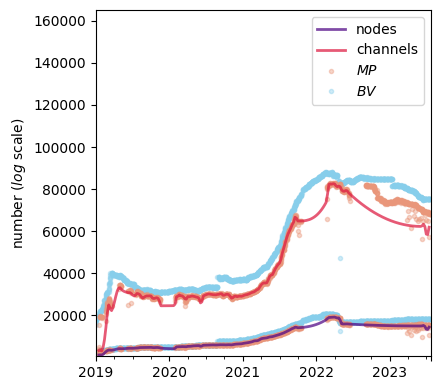

In [12]:
def fig1(file_name='fig1.png', show_figure=False, dpi=1200):
    bv = pd.read_csv(os.path.join(data_dir, 'bvisuals.csv'), 
                        parse_dates=True, index_col=0, sep=';')
    mt = pd.read_csv(os.path.join(data_dir, 'mempool.csv'), 
                        parse_dates=True, index_col=0, sep=';')
    mt.drop('capacity', axis=1, inplace=True)
    mt = mt[(mt['nodes'] > 1300)]
    fs = pd.read_csv(os.path.join(data_dir, 'shapes.csv'), parse_dates=True, index_col=1)\
        .rename(columns={'edges': 'channels'}).fillna(0)
    fs.drop(['file_name', 'timestamp'], axis=1, inplace=True)
    fs = fs.asfreq('D').interpolate(method='pchip').resample('1W').mean().astype(int)
    fig = plt.figure(figsize=(8, 4))
    
    ax = fig.add_subplot(1, 2, 1)
    fs.rename(columns={'nodes': '$A',
                    'channels': '$A'})\
                        .plot(ax=ax, linewidth=0.01)
    bv.rename(columns={'nodes': '$BV$',
                    'channels': '$A'})\
        .plot(ax=ax, style='.', lw=0.1, color='skyblue', 
            alpha=0.4)
    mt.rename(columns={'nodes': '$MP$',
                    'channels': '$A'})\
        .plot(ax=ax, style='.', color='darksalmon', 
            alpha=0.4)
    fs[['channels']].plot(ax=ax, linewidth=2, color='crimson', 
            alpha=0.7)
    fs[['nodes']].plot(ax=ax, linewidth=2, color='indigo', 
            alpha=0.7)

    ax.set_xlim(left=datetime(2019, 1, 1), right=datetime(2023, 7, 23))
    ax.set_ylabel('number ($log$ scale)')
    ax.set_xlabel(None)
    ax.set_ylim(bottom=500, top=fs.max(1).max() * 2)
    #ax.set_yscale('log')

    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), 
                                reverse=True,
                                key=lambda t: t[0]))
    ax.legend(handles[:4], labels[:4])

    fig.tight_layout()
    #fig.savefig(os.path.join(data_dir, file_name), dpi=dpi, bbox_inches='tight')
    if show_figure:
        plt.show()
fig1()

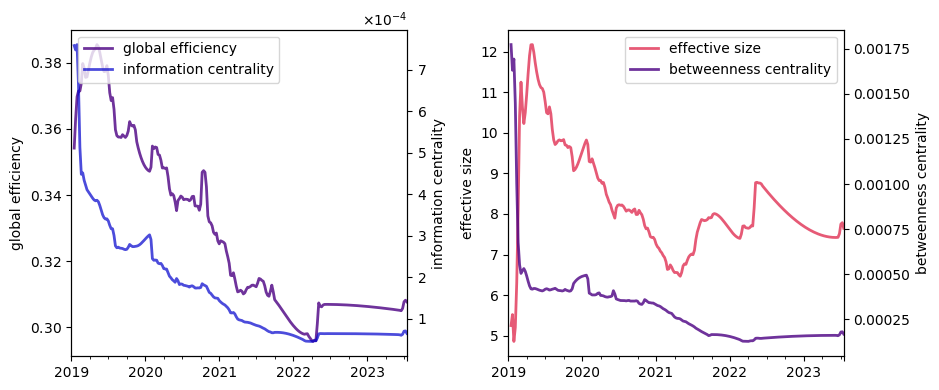

In [7]:
d = pd.read_csv(os.path.join(results_dir, "metrics.csv"),
                parse_dates=True, index_col=1)
xfmt = ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((0,0))
fig = plt.figure(figsize=(9.5, 4))
ax0 = fig.add_subplot(1, 2, 1)

b = d['global_efficiency'].asfreq('D').interpolate(method='pchip').resample('1W').mean()
b.plot(ax=ax0, linewidth=2, color='indigo', alpha=0.8, label='global efficiency')
ax0.yaxis.set_major_formatter(xfmt)
ax0.set_xlabel(None)
ax0.set_ylabel('global efficiency')
ax0.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
legend0 = [ax0.get_legend_handles_labels()]

ax = ax0.twinx()
b = d['information_centrality'].asfreq('D').interpolate(method='pchip').resample('1W').mean()
b.plot(ax=ax, linewidth=2, color='mediumblue', alpha=0.7, label='information centrality')
ax.yaxis.set_major_formatter(xfmt)
ax.set_xlabel(None)
ax.set_ylabel('information centrality')
ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
legend0 += [ax.get_legend_handles_labels()]

ax.legend(loc='upper left',
                    handles=[j for i in legend0 for j in i[0]],
                    labels=[j for i in legend0 for j in i[1]])

ax1 = fig.add_subplot(1, 2, 2)
b = d['effective_size'].asfreq('D').interpolate(method='pchip').resample('1W').mean()
b.plot(ax=ax1, linewidth=2, color='crimson', alpha=0.7, label='effective size')
ax1.set_xlabel(None)
ax1.set_ylabel('effective size')
ax1.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
legend1 = [ax1.get_legend_handles_labels()]

ax = ax1.twinx()
b = d['mean_betweenness_centrality'].asfreq('D').interpolate(method='pchip').resample('1W').mean()
b.plot(ax=ax, linewidth=2, color='indigo', alpha=0.8, label='betweenness centrality')
ax.set_xlabel(None)
ax.set_ylabel('betweenness centrality')
ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
legend1 += [ax.get_legend_handles_labels()]

ax.legend(loc='upper right',
                    handles=[j for i in legend1 for j in i[0]],
                    labels=[j for i in legend1 for j in i[1]])
fig.tight_layout()

In [3]:
import nx_parallel as nxp
print(f"networkx: {nx.__version__}")
print(f"nx_parallel: {nxp.__version__}")
os.environ['NETWORKX_AUTOMATIC_BACKENDS'] = "parallel"
os.environ['RAY_memory_monitor_refresh_ms'] = '0'
nx.config.backends.parallel.active = True
nx.config.backends.parallel.n_jobs = 10

networkx: 3.4.2
nx_parallel: 0.3


In [11]:
g = nx.read_gml('data/20190120.gml.gz.fix').to_undirected()
components = [g.subgraph(c) 
                    for c in sorted(nx.connected_components(g), 
                                    key=len, reverse=True) if len(c) > 10]
#g = components[0]

In [12]:
v = list(nx.communicability_betweenness_centrality(g).values())

In [13]:
np.mean(v)

np.float64(nan)

In [ ]:
v

In [39]:
v = []
wi = nx.wiener_index(g)
for n in list(g.nodes)[:10]:
    v += [nx.closeness_vitality(g, node=n, wiener_index=wi)]

v


[3013.0, 3013.0, 3013.0, 3013.0, 3947.0, 3013.0, 4680.0, 3007.0, 3978.0, -inf]

In [43]:
myarray = np.array(v)
myarray[np.isfinite(myarray)].mean() 

np.float64(3408.5555555555557)

In [46]:
myarray[np.isfinite(myarray)]

array([3013., 3013., 3013., 3013., 3947., 3013., 4680., 3007., 3978.])

In [4]:
def communicability_betweenness_centrality(g, copy=True):
    try:
        if copy:
            g = deepcopy(g)
        return np.mean(list(nx.communicability_betweenness_centrality(g).values()))
    except Exception as e:
        print(e)

In [ ]:
list(nx.communicability_betweenness_centrality(g).values())

In [ ]:
list(nx.closeness_vitality(g, node=list(g.nodes)[0]).values())

In [ ]:
nx.closeness_vitality(g, node=list(g.nodes)[-1])

In [3]:
d = pd.read_csv(os.path.join(results_dir, "metrics.csv"),
                parse_dates=True, index_col=1)

In [ ]:
d['bridges'].plot(), 
#d['min_edge_cover'].plot()
d['transitivity'].plot(), 
d['average_clustering'].plot()
#d['average_node_connectivity'].plot()

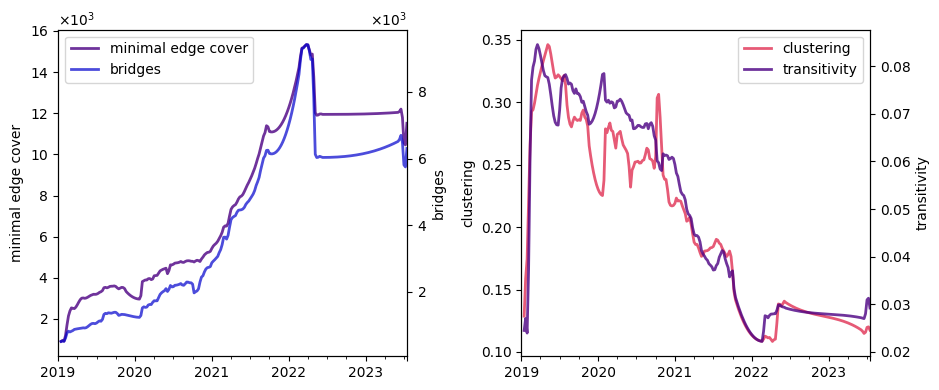

In [61]:
d = pd.read_csv(os.path.join(results_dir, "metrics.csv"),
                parse_dates=True, index_col=1)
xfmt = ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((0,0))
fig = plt.figure(figsize=(9.5, 4))
ax0 = fig.add_subplot(1, 2, 1)

b = d['min_edge_cover'].asfreq('D').interpolate(method='pchip').resample('1W').mean()
b.plot(ax=ax0, linewidth=2, color='indigo', alpha=0.8, label='minimal edge cover')
ax0.yaxis.set_major_formatter(xfmt)
ax0.set_xlabel(None)
ax0.set_ylabel('minimal edge cover')
ax0.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
legend0 = [ax0.get_legend_handles_labels()]

ax = ax0.twinx()
b = d['bridges'].asfreq('D').interpolate(method='pchip').resample('1W').mean()
b.plot(ax=ax, linewidth=2, color='mediumblue', alpha=0.7, label='bridges')
ax.yaxis.set_major_formatter(xfmt)
ax.set_xlabel(None)
ax.set_ylabel('bridges')
ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
legend0 += [ax.get_legend_handles_labels()]

ax.legend(loc='upper left',
                    handles=[j for i in legend0 for j in i[0]],
                    labels=[j for i in legend0 for j in i[1]])

ax1 = fig.add_subplot(1, 2, 2)
b = d['average_clustering'].asfreq('D').interpolate(method='pchip').resample('1W').mean()
b.plot(ax=ax1, linewidth=2, color='crimson', alpha=0.7, label='clustering')
ax1.set_xlabel(None)
ax1.set_ylabel('clustering')
ax1.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
legend1 = [ax1.get_legend_handles_labels()]

ax = ax1.twinx()
b = d['transitivity'].asfreq('D').interpolate(method='pchip').resample('1W').mean()
b.plot(ax=ax, linewidth=2, color='indigo', alpha=0.8, label='transitivity')
ax.set_xlabel(None)
ax.set_ylabel('transitivity')
ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
legend1 += [ax.get_legend_handles_labels()]

ax.legend(loc='upper right',
                    handles=[j for i in legend1 for j in i[0]],
                    labels=[j for i in legend1 for j in i[1]])
fig.tight_layout()

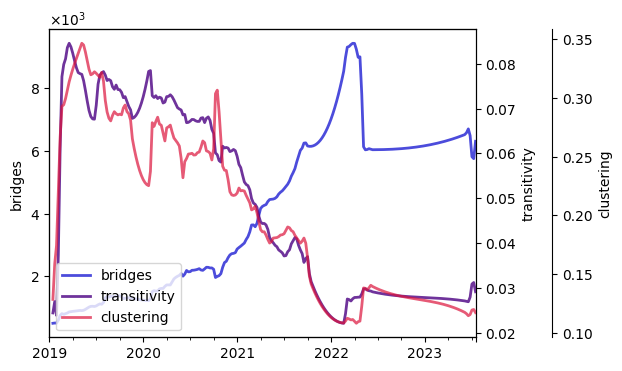

In [42]:
d = pd.read_csv(os.path.join(results_dir, "metrics.csv"),
                parse_dates=True, index_col=1)
xfmt = ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((0,0))
fig = plt.figure(figsize=(5.5, 4))
ax0 = fig.add_subplot()

b = d['bridges'].asfreq('D').interpolate(method='pchip').resample('1W').mean()
b.plot(ax=ax0, linewidth=2, color='mediumblue', alpha=0.7, label='bridges')
ax0.yaxis.set_major_formatter(xfmt)
ax0.set_xlabel(None)
ax0.set_ylabel('bridges')
ax0.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
legend = [ax0.get_legend_handles_labels()]
#ax0.get_legend().remove()
#ax0.legend(loc='lower left')

ax = ax0.twinx()
b = d['transitivity'].asfreq('D').interpolate(method='pchip').resample('1W').mean()
b.plot(ax=ax, linewidth=2, color='indigo', alpha=0.8, label='transitivity')
ax.set_xlabel(None)
ax.set_ylabel('transitivity')
ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
legend += [ax.get_legend_handles_labels()]
#ax.get_legend().remove()
#ax.legend(loc='upper right')

ax = ax0.twinx()
b = d['average_clustering'].asfreq('D').interpolate(method='pchip').resample('1W').mean()
b.plot(ax=ax, linewidth=2, color='crimson', alpha=0.7, label='clustering')
ax.spines.right.set_position(("axes", 1.18))
ax.set_xlabel(None)
ax.set_ylabel('clustering')
ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
legend += [ax.get_legend_handles_labels()]
#ax.get_legend().remove()
#ax.legend(loc='upper right')
ax.legend(loc='lower left',
                    handles=[j for i in legend for j in i[0]],
                    labels=[j for i in legend for j in i[1]])

(<Axes: >, <Axes: >)

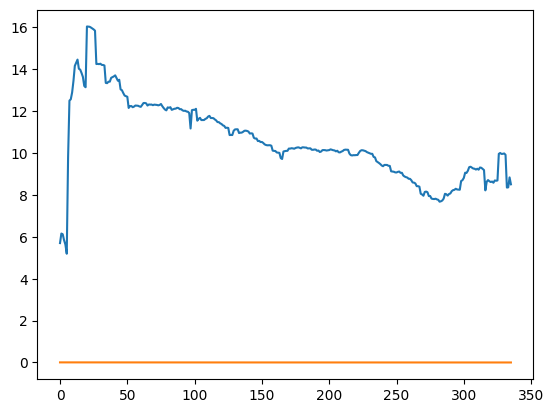

In [46]:
d['mean_degree'].plot(), d['density'].plot(), 

<Axes: >

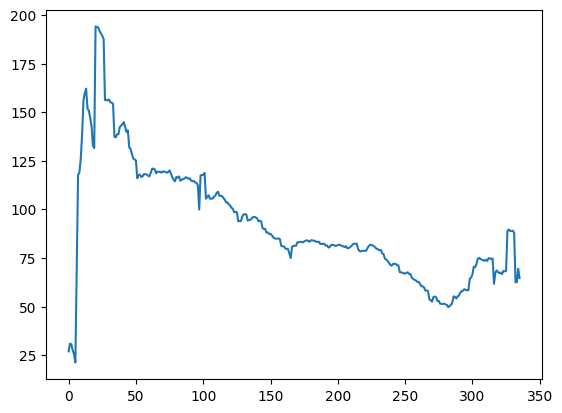

In [40]:
d['preferential_attachment'].plot()

<Axes: >

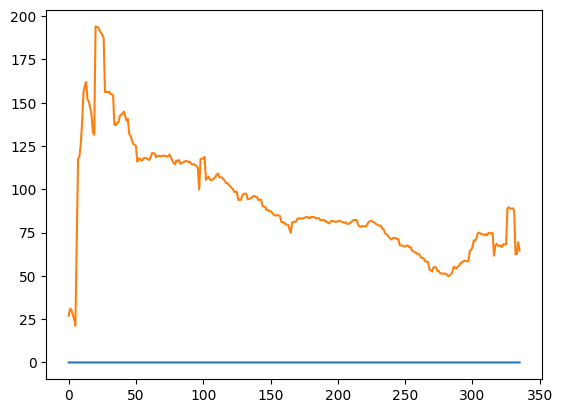

In [44]:
(d['mean_degree'] / d['nodes']).plot()
(d['preferential_attachment']).plot()

<Axes: >

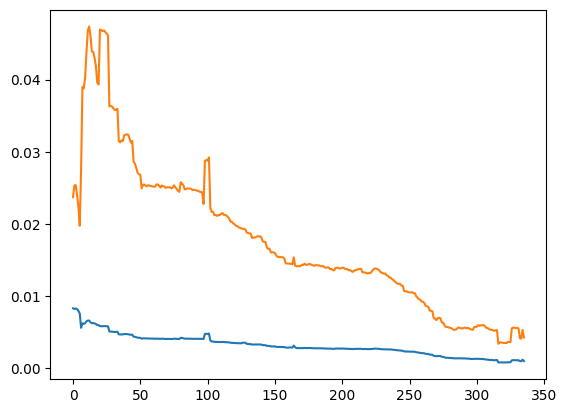

In [26]:
(d['preferential_attachment'] / d['edges']).plot()
(d['preferential_attachment'] / d['nodes']).plot()

In [55]:
pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/11.1 MB 11.2 MB/s eta 0:00:01
   ----------- ---------------------------- 3.1/11.1 MB 12.3 MB/s eta 0:00:01
   --------------------- ------------------ 6.0/11.1 MB 10.9 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.1 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 11.2 MB/s eta 0:00:00
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


df = pd.DataFrame({
            'x': [ 1000, 3250, 5500, 10000, 32500, 55000, 77500, 100000, 200000 ],
            'y': [ 1100, 500, 288, 200, 113, 67, 52, 44, 5 ]
        })

0.808515298155005 [15.68576294 -1.43225541]


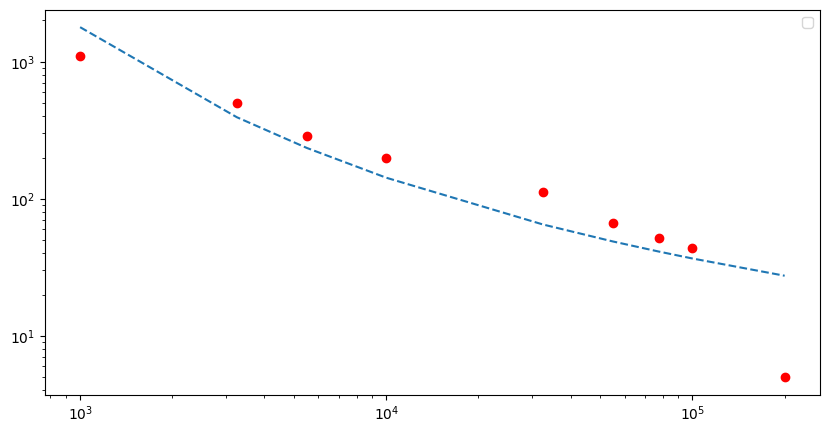

In [80]:
def fit_powlaw(xdata, ydata):
    """Fit data to a power law with weights according to a log scale"""
    def powlaw(x, a, b) :
        return a * np.power(x, b)

    xdata_log = np.log10(xdata)
    ydata_log = np.log10(ydata)
    popt, pcov = curve_fit(powlaw, xdata_log, ydata_log)
    y_pred = powlaw(xdata_log, *popt)
    y_fitted = np.power(10, y_pred)
    r_squared = r2_score(ydata_log, y_pred)
    return popt, pcov, y_fitted, r_squared



X = df['x']
y = df['y']

popt, pcov, f, r_squared = fit_powlaw(X, y)
print(r_squared, popt)
plt.figure(figsize=(10, 5))
plt.plot(X, f, '--')
plt.plot(X, y, 'ro')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [79]:
f

0    1786.352366
1     393.634268
2     235.008542
3     142.489578
4      64.950670
5      48.839522
6      41.264706
7      36.694037
8      27.473899
Name: x, dtype: float64

In [65]:
g = nx.read_gml('data/20200830.gml.gz').to_undirected()

In [66]:
c = np.array(g.degree)[:, 1].astype('float64')
p = pd.Series(c).value_counts() / len(g.nodes)

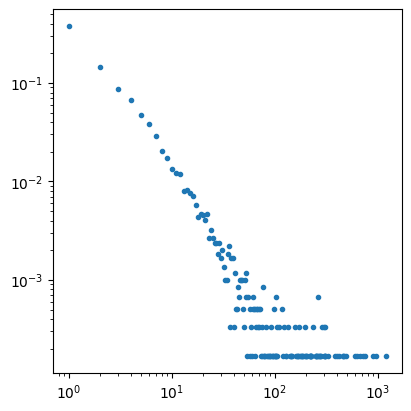

In [67]:
fig = plt.figure(figsize=(4, 4), layout="constrained")
ax = fig.subplots()
#ax.ecdf(c, label="CDF")
p.plot(ax=ax, style='.')
ax.set_xscale('log')
ax.set_yscale('log')

0.8293118786582491 [-2.23290863  0.60458811]


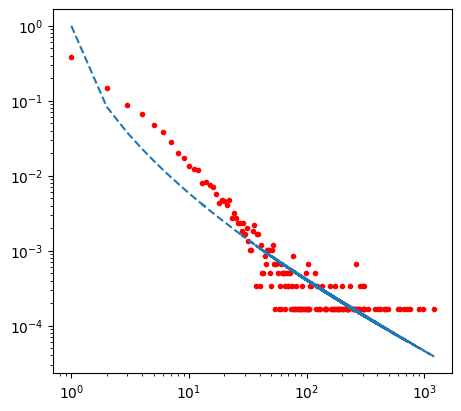

In [89]:
popt, pcov, y_fitted, r_squared = fit_powlaw(p.index, p)
print(r_squared, popt)

fig = plt.figure(figsize=(4.5, 4), layout="constrained")
ax = fig.subplots()
#ax.ecdf(c, label="CDF")
p.plot(ax=ax, style='r.')
ax.plot(p.index, y_fitted, '--')
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

In [33]:
p

1.0      0.380135
2.0      0.146465
3.0      0.087542
4.0      0.066498
5.0      0.047306
           ...   
78.0     0.000168
101.0    0.000168
94.0     0.000168
184.0    0.000168
100.0    0.000168
Name: count, Length: 163, dtype: float64

In [45]:
def gini_coefficient(values):
    """Calculate the Gini coefficient of a numpy array."""
    # https://github.com/oliviaguest/gini
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    x = np.array(values).flatten() #all values are treated equally, arrays must be 1d
    x = x[x > 0.00001]
    if np.amin(x) < 0:
        x -= np.amin(x) # values cannot be negative
    x += 0.0000001 # values cannot be 0
    x = np.sort(x) # values must be sorted
    n = x.shape[0] # number of array elements
    index = np.arange(1, n+1) # index per array element
    return ((np.sum((2 * index - n  - 1) * x)) / (n * np.sum(x))) # Gini coefficient

In [4]:
zero_capacity_edges = [e for e in g.edges if int(g.edges[e].get('htlc_maximum_msat', 0)) == 0]

In [5]:
len(zero_capacity_edges)

3

In [23]:
capacities = [(e[0], float(g.edges[e]['htlc_maximum_msat'])) for e in g.edges if 'htlc_maximum_msat' in g.edges[e]] +\
             [(e[1], float(g.edges[e]['htlc_maximum_msat'])) for e in g.edges if 'htlc_maximum_msat' in g.edges[e]]

In [37]:
c = pd.DataFrame(capacities).groupby(0).sum()[1].rename('shared capacity')

NameError: name 'c' is not defined

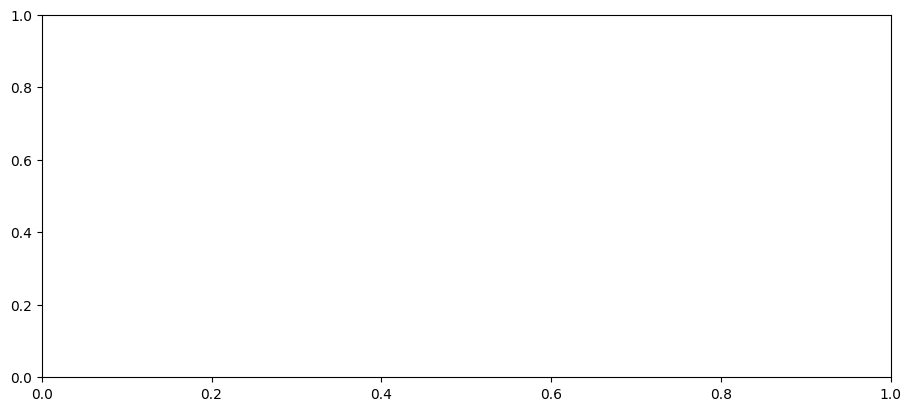

In [ ]:
fig = plt.figure(figsize=(9, 4), layout="constrained")
ax = fig.subplots()
ax.ecdf(c, label="CDF")
ax.set_xscale('log')
ax.set_yscale('log')

In [39]:
gini_coefficient(c)

np.float64(0.9161530223286795)

In [18]:
g.edges[e[100
          
          ]]

{'scid': '567977x2173x1/0',
 'destination': '0357706e9a6866e5d73838b6ad2c2027ab9cd799583ffc37f43e2bc3250e840e78',
 'timestamp': 1598618440,
 'features': '',
 'fee_base_msat': 0,
 'fee_proportional_millionths': 12000,
 'htlc_minimim_msat': 1000,
 'htlc_maximum_msat': 978258000,
 'cltv_expiry_delta': 40}

In [43]:
with open(os.path.join(results_dir, 'gini_metrics.pkl'), 'rb') as f:
    gini_m = pickle.load(f)

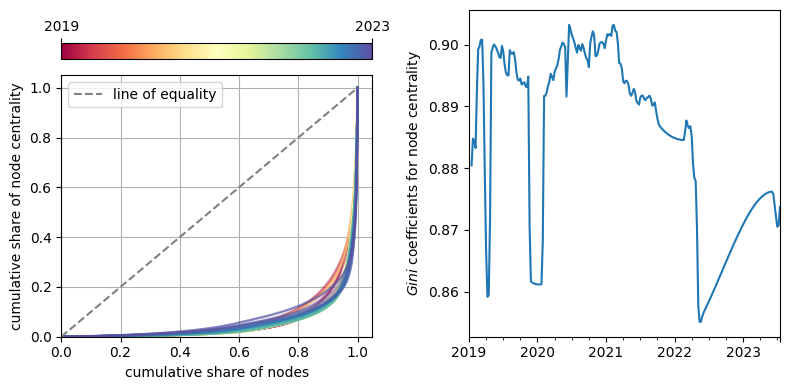

In [47]:
def plot_lorenz_curves(values):
    """
    Plot the Lorenz curves for visualization.
    """
    fig = plt.figure(figsize=(8., 4))

    ax = fig.add_subplot(1, 2, 1)
    cmap = plt.cm.Spectral(np.linspace(0, 1, len(values)))
    cmap[:, 3] = 0.2
    ax.set_prop_cycle('color', cmap)
    for v in values.values():
        sorted_vals = np.sort(np.array(v))
        sorted_vals = sorted_vals[sorted_vals > 0.00001]
        cumvals = np.cumsum(sorted_vals)
        cumvals = np.insert(cumvals, 0, 0)  # for a zero start
        cumvals = cumvals / cumvals[-1]  # normalize
        x = np.linspace(0, 1, len(cumvals))
        ax.plot(x, cumvals, label=None)

    ax.plot([0, 1], [0, 1], '--', color='gray', label='line of equality')
    plt.pcolor(np.random.rand(0, 0), cmap='Spectral')
    cbar = plt.colorbar(ax=ax, location="top")
    keys = list(values.keys())
    cbar.set_ticks(ticks=[0, 1], labels=[keys[0][:4], keys[-1][:4]])
    #plt.title('Lorenz Curve of Betweenness Centrality')
    ax.set_xlabel('cumulative share of nodes')
    ax.set_ylabel('cumulative share of node centrality')
    plt.grid(True)
    plt.legend()
    ax = fig.add_subplot(1, 2, 2)
    gini = [gini_coefficient(v) for v in values.values()]
    gini = pd.Series(data=gini, index=values.keys())
    gini.index = pd.to_datetime(gini.index, format="%Y%m%d")
    gini = gini.asfreq('D').interpolate(method='pchip').resample('1W').mean()
    gini.plot(ax=ax)
    ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
    ax.set_ylabel('$Gini$ coefficients for node centrality')
    ax.set_xlabel(None)
    
    fig.tight_layout()
    #fig.savefig(os.path.join(results_dir, 'fig4.png'), dpi=1200, bbox_inches='tight')
    plt.show()

plot_lorenz_curves(gini_m)

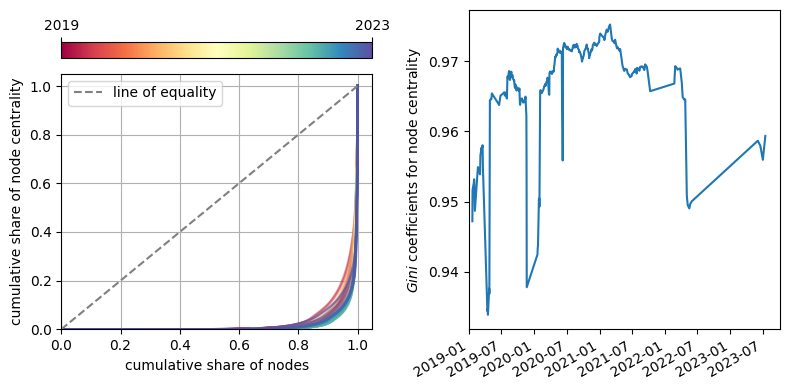

In [44]:
def plot_lorenz_curves(values):
    """
    Plot the Lorenz curves for visualization.
    """
    fig = plt.figure(figsize=(8., 4))

    ax = fig.add_subplot(1, 2, 1)
    cmap = plt.cm.Spectral(np.linspace(0, 1, len(values)))
    cmap[:, 3] = 0.2
    ax.set_prop_cycle('color', cmap)
    for v in values.values():
        sorted_vals = np.sort(np.array(v))
        cumvals = np.cumsum(sorted_vals)
        cumvals = np.insert(cumvals, 0, 0)  # for a zero start
        cumvals = cumvals / cumvals[-1]  # normalize
        x = np.linspace(0, 1, len(cumvals))
        ax.plot(x, cumvals, label=None)

    ax.plot([0, 1], [0, 1], '--', color='gray', label='line of equality')
    plt.pcolor(np.random.rand(0, 0), cmap='Spectral')
    cbar = plt.colorbar(ax=ax, location="top")
    keys = list(values.keys())
    cbar.set_ticks(ticks=[0, 1], labels=[keys[0][:4], keys[-1][:4]])
    #plt.title('Lorenz Curve of Betweenness Centrality')
    ax.set_xlabel('cumulative share of nodes')
    ax.set_ylabel('cumulative share of node centrality')
    plt.grid(True)
    plt.legend()
    ax = fig.add_subplot(1, 2, 2)
    gini = [gini_coefficient(v) for v in values.values()]
    gini = pd.Series(data=gini, index=values.keys())
    gini.index = pd.to_datetime(gini.index, format="%Y%m%d")
    ginni = gini.asfreq('D').interpolate(method='pchip').resample('1W').mean()
    gini.plot(ax=ax)
    ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
    ax.set_ylabel('$Gini$ coefficients for node centrality')
    ax.set_xlabel(None)
    
    fig.tight_layout()
    #fig.savefig(os.path.join(results_dir, 'fig4.png'), dpi=1200, bbox_inches='tight')
    plt.show()

plot_lorenz_curves(gini_m)

In [76]:
def gini_coefficient_np(values):
    x = np.array(values).flatten()
    if np.amin(x) < 0:
        x -= np.amin(x) #values cannot be negative
    x += 0.0000001 #values cannot be 0
    return np.sum(np.abs(np.subtract.outer(x, x)))/(2*len(x)**2*x.mean())


def gini_coefficient(values):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    x = np.array(values).flatten() #all values are treated equally, arrays must be 1d
    if np.amin(x) < 0:
        x -= np.amin(x) #values cannot be negative
    x += 0.0000001 #values cannot be 0
    x = np.sort(x) #values must be sorted
    n = x.shape[0] #number of array elements
    index = np.arange(1, n+1) #index per array element
    
    return ((np.sum((2 * index - n  - 1) * x)) / (n * np.sum(x))) #Gini coefficient

Gini coefficient: 0.4802


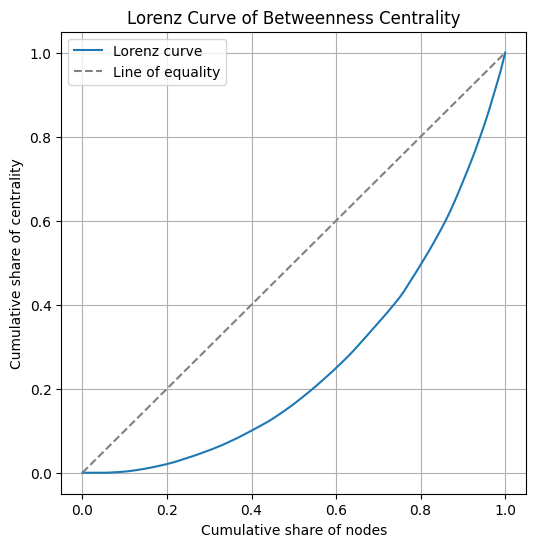

In [75]:
def gini_coefficient(values):
    """
    Calculate the Gini coefficient from a list or numpy array of values.
    """
    sorted_vals = np.sort(np.array(values))
    n = len(sorted_vals)
    cumvals = np.cumsum(sorted_vals)
    index = np.arange(1, n+1)
    gini = (np.sum((2 * index - n - 1) * sorted_vals)) / (n * np.sum(sorted_vals))
    return gini

def plot_lorenz_curve(values):
    """
    Plot the Lorenz curve for visualization.
    """
    sorted_vals = np.sort(np.array(values))
    cumvals = np.cumsum(sorted_vals)
    cumvals = np.insert(cumvals, 0, 0)  # for a zero start
    cumvals = cumvals / cumvals[-1]  # normalize
    x = np.linspace(0, 1, len(cumvals))
    
    plt.figure(figsize=(6, 6))
    plt.plot(x, cumvals, label='Lorenz curve')
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Line of equality')
    plt.title('Lorenz Curve of Betweenness Centrality')
    plt.xlabel('Cumulative share of nodes')
    plt.ylabel('Cumulative share of centrality')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with a sample graph
G = nx.erdos_renyi_graph(n=100, p=0.05, directed=False)

# You can use weight='weight' if your graph has edge weights
betweenness = nx.betweenness_centrality(G, weight=None)

# Extract centrality values
centrality_values = list(betweenness.values())

# Calculate Gini coefficient
gini = gini_coefficient(centrality_values)
print(f"Gini coefficient: {gini:.4f}")

# Optional: plot the Lorenz curve
plot_lorenz_curve(centrality_values)


In [73]:
g = nx.read_gml('data/20200830.gml.gz').to_undirected()
components = [g.subgraph(c) for c in nx.connected_components(g) if len(c) > 10]
len(components)

1

In [78]:
G = g

Gini coefficient: 0.9722


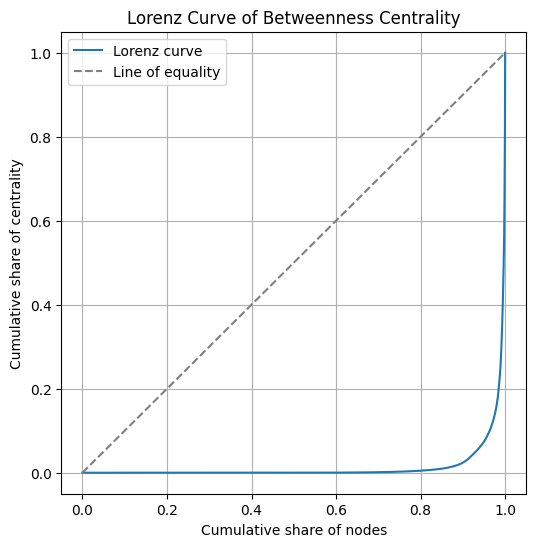

In [79]:
# You can use weight='weight' if your graph has edge weights
betweenness = nx.betweenness_centrality(G, weight=None)

# Extract centrality values
centrality_values = list(betweenness.values())

# Calculate Gini coefficient
gini = gini_coefficient(centrality_values)
print(f"Gini coefficient: {gini:.4f}")

# Optional: plot the Lorenz curve
plot_lorenz_curve(centrality_values)

In [9]:
def gini(x):
    x = np.array(x)
    return np.sum(np.abs(np.subtract.outer(x, x)))/(2*len(x)**2*x.mean())

In [10]:
gini(centrality_values)

np.float64(0.9724137499397486)

In [72]:
%%time
gini_coefficient_np(centrality_values)

CPU times: total: 203 ms
Wall time: 207 ms


np.float64(0.9721399297108734)

In [63]:
%%time
gini_coefficient(centrality_values)

CPU times: total: 0 ns
Wall time: 2 ms


np.float64(0.9721399297108702)

In [12]:
def gini_coefficient1(x):
    x = sorted(x)
    n = len(x)
    s = sum(x)
    d = n * s
    G = sum(xi * (n - i) for i, xi in enumerate(x))
    return (d + s - 2 * G) / d

In [86]:
pd.DataFrame.from_dict({'a': 1., 'b': 3.}, orient='index').rename(columns={0: 'gini'}).reset_index(names='timestamp')

,timestamp,gini
0,a,1.0
1,b,3.0


In [14]:
d = [50,50,50,50,50,50,1,1,1,1,1,1]

In [15]:
gini_coefficient1(d)

0.4803921568627451

In [16]:
gini_coefficient(d)

np.float64(0.4803921568627451)

In [17]:
gini(d)

np.float64(0.4803921568627451)

In [18]:
gini(np.ones((1000)))

np.float64(0.0)

In [40]:
bv_nodes = pd.read_csv(os.path.join(data_dir, 'bv_nodes.csv'), 
                       parse_dates=True, index_col=0, sep=';')\
            .fillna(0).sum(1).rename('nodes').astype(int)
bv_edges = pd.read_csv(os.path.join(data_dir, 'bv_channels.csv'), 
                       parse_dates=True, index_col=0, sep=';').fillna(0)\
            .rename(columns={'Total.1': 'channels'})['channels']
bv_shapes = pd.concat([bv_nodes, bv_edges], axis=1)

In [43]:
bv_shapes.to_csv('bvisuals.csv', sep=';', index=True)

In [30]:
with open(os.path.join(data_dir, 'channels.json'), 'r') as f:
    d = json.load(f)
    d = pd.DataFrame(d)
    d['datetime'] = d['added'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    d['nodes'] = d['tor_nodes'] + d['clearnet_nodes'] + d['unannounced_nodes'] + d['clearnet_tor_nodes']
    d['capacity'] = d['total_capacity']
    d['channels'] = d['channel_count']
    d = d[['datetime', 'nodes', 'channels', 'capacity']]
d.to_csv('memtool.csv', sep=';', index=False)


In [20]:
with open(os.path.join(data_dir, 'channels2.json'), 'r') as f:
    d = json.load(f)
    d = pd.DataFrame(d)
    d['datetime'] = d['added'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    d['nodes'] = d['tor_nodes'] + d['clearnet_nodes'] + d['unannounced_nodes'] + d['clearnet_tor_nodes']
    d['capacity'] = d['total_capacity']
    d['channels'] = d['channel_count']
    d = d[['datetime', 'nodes', 'channels', 'capacity']]
d.iloc[35:]

,datetime,nodes,channels,capacity
35,2025-03-13 00:00:00,13610,38373,462534441613
36,2025-03-12 00:00:00,16755,42629,467518351471
37,2025-03-11 00:00:00,16763,42606,465893867342
38,2025-03-10 00:00:00,16775,42549,468206048976
39,2025-03-09 00:00:00,16799,42842,471753135391
...,...,...,...,...
2116,2018-03-25 00:00:00,6,3,17327216
2117,2018-03-24 00:00:00,4,2,550000
2118,2018-03-23 00:00:00,2,1,50000
2119,2018-03-22 00:00:00,2,1,50000


In [44]:
lit = pd.read_csv(os.path.join(data_dir, 'literature.csv'), 
                       parse_dates=True, index_col=0, sep=';')
lit = pd.concat([lit.nodes, lit.channels], axis=0)

In [34]:
me = pd.read_csv(os.path.join(data_dir, 'memtool.csv'), 
                       parse_dates=True, index_col=0, sep=';')
me = me.asfreq('D').interpolate(method='pchip').resample('1W').mean().astype(int)

In [ ]:
g = nx.read_gml('data/20200830.gml.gz').to_undirected()
components = [g.subgraph(c) for c in nx.connected_components(g) if len(c) > 10]
len(components)

1

In [15]:
def closeness_vitality(g, copy=True):
    try:
        if copy:
            g = deepcopy(g)
        #g.__networkx_cache__ = None
        return np.nanmean(list(nx.closeness_vitality(g).values()))
    except Exception as e:
        print(e)

In [16]:
closeness_vitality(g)

np.float64(nan)

In [26]:
shapes = pd.read_csv(os.path.join(results_dir, 'shapes.csv'), parse_dates=True, index_col=0)\
    .rename(columns={'edges': 'channels'}).fillna(0)
shapes.drop(['keep', 'fname'], axis=1, inplace=True)
shapes = shapes.asfreq('D').interpolate(method='pchip').resample('1W').mean().astype(int)
msgs = pd.read_csv(os.path.join(results_dir, 'messages.csv'), parse_dates=True, index_col=0, compression='zip').fillna(0)
msgs['node_announcements\nand_updates'] = msgs['node_announcements']
msgs['channel_announcements\nand_updates'] = msgs['channel_updates'] + msgs['channel_announcements']
msgs.drop(['channel_announcements', 'channel_updates', 'node_announcements'], axis=1, inplace=True)
msgs.columns = [i.replace('_', ' ') for i in msgs.columns]
msgs = msgs.resample('1W').sum().cumsum()

In [45]:
bv_nodes = pd.read_csv(os.path.join(data_dir, 'bv_nodes.csv'), 
                       parse_dates=True, index_col=0, sep=';')\
            .fillna(0).sum(1).rename('nodes (BV)')
bv_edges = pd.read_csv(os.path.join(data_dir, 'bv_channels.csv'), 
                       parse_dates=True, index_col=0, sep=';').fillna(0)\
            .rename(columns={'Total.1': 'channels (BV)'})['channels (BV)']
bv_shapes = pd.concat([bv_nodes, bv_edges], axis=1)
bv_shapes = bv_shapes.asfreq('D').interpolate(method='pchip').resample('1W').mean().astype(int)


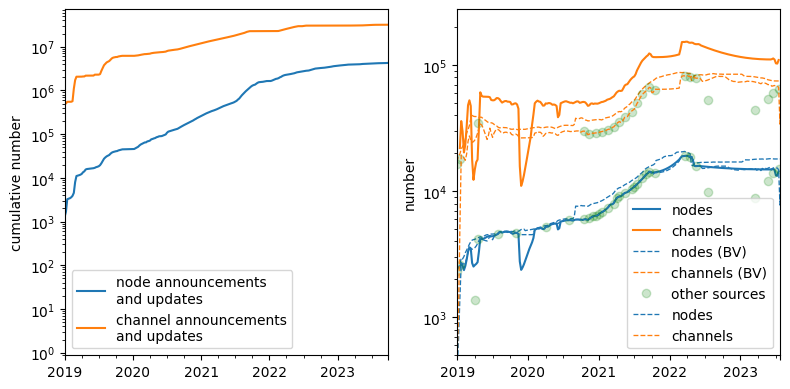

In [ ]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(1, 2, 1)
msgs.plot(ax=ax)
ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
ax.set_ylabel('cumulative number')
ax.set_xlabel(None)
xfmt = ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((0, 0))
#ax.yaxis.set_major_formatter(xfmt)
ax.set_yscale('log')

ax = fig.add_subplot(1, 2, 2)
shapes.plot(ax=ax)

plt.gca().set_prop_cycle(None)
bv_shapes.plot(ax=ax, style='--', linewidth=0.95)

plt.gca().set_prop_cycle(None)
lit.plot(ax=ax, style='o', linewidth=.1, color='green', alpha=0.2, label='other sources', legend=True)

plt.gca().set_prop_cycle(None)
me[['nodes', 'channels']].plot(ax=ax, style='--', linewidth=0.95)

ax.set_xlim(left=datetime(2019, 1, 1), right=datetime(2023, 7, 23))
ax.set_ylabel('number')
ax.set_xlabel(None)
ax.set_yscale('log')
xfmt = ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((0, 0))
ax.set_ylim(bottom=500)
#ax.yaxis.set_major_formatter(xfmt)

fig.tight_layout()
#fig.savefig('fig1.png', dpi=600, bbox_inches='tight')
#plt.show()

In [16]:
with open(os.path.join(results_dir, 'tx_metrics.pkl'), 'rb') as f:
    tx_m = pickle.load(f)

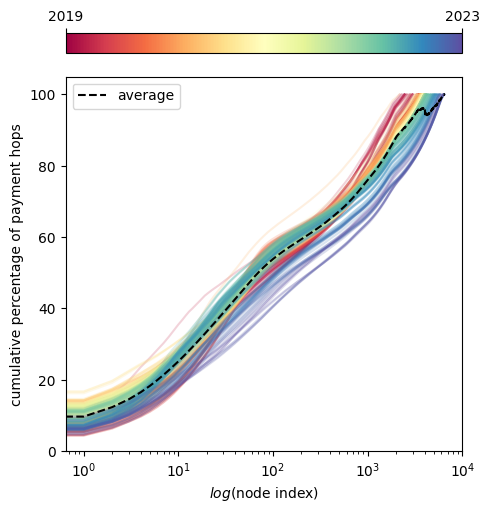

In [26]:
fig = plt.figure(figsize=(5, 5.5))

ax = fig.add_subplot()
cmap = plt.cm.Spectral(np.linspace(0, 1, len(tx_m)))
cmap[:, 3] = 0.2
ax.set_prop_cycle('color', cmap)
for k, v in tx_m.items():
    v.plot(ax=ax)
pd.DataFrame(tx_m).mean(1).rename('average').plot(ax=ax, color='black', style='--', legend=True)
ax.set_xscale('log')
ax.set_xlabel('$log$(node index)')
ax.set_ylabel('cumulative percentage of payment hops')
plt.pcolor(np.random.rand(0, 0), cmap='Spectral')
cbar = plt.colorbar(location="top")
keys = list(tx_m.keys())
cbar.set_ticks(ticks=[0, 1], labels=[keys[0][:4], keys[-1][:4]])

fig.tight_layout()
fig.savefig('fig2.png', dpi=600, bbox_inches='tight')
#plt.show()

In [62]:
_mextra = pd.read_csv(os.path.join(results_dir, 'extra_metrics.csv'), parse_dates=True, index_col=0)
print(_mextra.describe().drop(['25%', '50%', '75%']))
mextra = _mextra.asfreq('D').interpolate(method='pchip').resample('1W').mean()

       nodes_intersect_rate  edges_intersect_rate  \
count            352.000000            352.000000   
mean               0.984622              0.980193   
std                0.044202              0.039590   
min                0.647515              0.661136   
max                1.000000              0.997642   

       sampled_nodes_intersect_rate_mean  sampled_edges_intersect_rate_mean  \
count                         352.000000                         352.000000   
mean                            0.995709                           0.989778   
std                             0.016559                           0.034955   
min                             0.782700                           0.643228   
max                             1.000000                           1.000000   

       sampled_nodes_intersect_rate_median  \
count                           352.000000   
mean                              0.997131   
std                               0.016208   
min                   

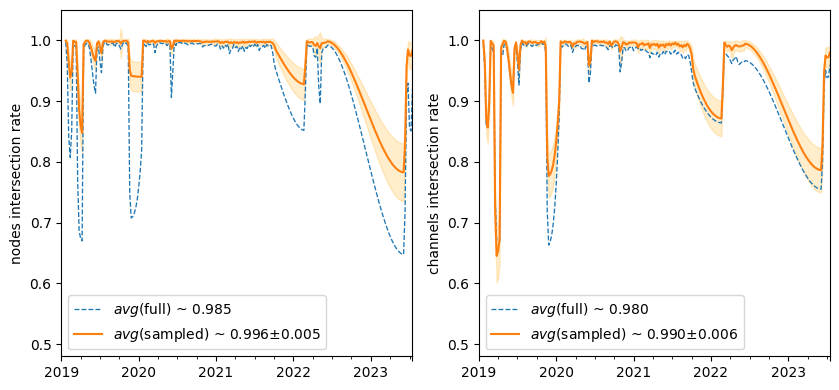

In [64]:
fig = plt.figure(figsize=(8.5, 4))

ax = fig.add_subplot(1, 2, 1)
mextra[["nodes_intersect_rate"]].plot(ax=ax, style='--', linewidth=0.95)
mextra[["sampled_nodes_intersect_rate_mean"]].plot(ax=ax)
lower = mextra["sampled_nodes_intersect_rate_mean"] - mextra["sampled_nodes_intersect_rate_std"]
upper = mextra["sampled_nodes_intersect_rate_mean"] + mextra["sampled_nodes_intersect_rate_std"]
ax.fill_between(mextra.index, lower, upper, alpha=0.2, color='orange')

ax.legend([f"$avg$(full) ~ {_mextra['nodes_intersect_rate'].mean():.3f}", 
           f"$avg$(sampled) ~ {_mextra['sampled_nodes_intersect_rate_mean'].mean():.3f}±{_mextra['sampled_nodes_intersect_rate_std'].mean():.3f}"])
ax.set_ylim((0.48, 1.05))
ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
ax.set_ylabel('nodes intersection rate')
ax.set_xlabel(None)

ax = fig.add_subplot(1, 2, 2)
mextra[["edges_intersect_rate"]].plot(ax=ax, style='--', linewidth=0.95)
mextra[["sampled_edges_intersect_rate_mean"]].plot(ax=ax)
lower = mextra["sampled_edges_intersect_rate_mean"] - mextra["sampled_edges_intersect_rate_std"]
upper = mextra["sampled_edges_intersect_rate_mean"] + mextra["sampled_edges_intersect_rate_std"]
ax.fill_between(mextra.index, lower, upper, alpha=0.2, color='orange')

ax.legend([f"$avg$(full) ~ {_mextra['edges_intersect_rate'].mean():.3f}", 
           f"$avg$(sampled) ~ {_mextra['sampled_edges_intersect_rate_mean'].mean():.3f}±{_mextra['sampled_edges_intersect_rate_std'].mean():.3f}"])
ax.set_ylim((0.48, 1.05))
ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
ax.set_ylabel('channels intersection rate')
ax.set_xlabel(None)

fig.tight_layout()
fig.savefig('fig3.png', dpi=600, bbox_inches='tight')
#plt.show()


In [20]:
_mbase = pd.read_csv(os.path.join(results_dir, 'base_metrics.csv'), parse_dates=True, index_col=0)
print(_mbase.describe().drop(['25%', '50%', '75%']))
mbase = _mbase.asfreq('D').interpolate(method='pchip').resample('1W').mean()

              nodes          edges  mean_diameter  std_diameter  max_diameter  \
count    353.000000     353.000000     353.000000    353.000000    353.000000   
mean    6516.252125   58149.283286       1.886171      1.965831      7.484419   
std     3457.952869   26228.838084       0.558550      0.510261      0.911050   
min     2330.000000   10645.000000       1.110000      0.810573      6.000000   
max    19155.000000  154334.000000       4.500000      3.726780     11.000000   

       mean_degree  std_degree   max_degree  components     density  \
count   353.000000  353.000000   353.000000  353.000000  353.000000   
mean     18.662712   75.659858  2289.379603   15.008499    0.001779   
std       3.839602   10.979637   908.035741   18.210962    0.000919   
min       8.629674   26.690673   553.000000    2.000000    0.000372   
max      29.768331  104.222026  5421.000000  101.000000    0.004990   

           bridges  path_length  transitivity  clustering  assortativity  
count   353

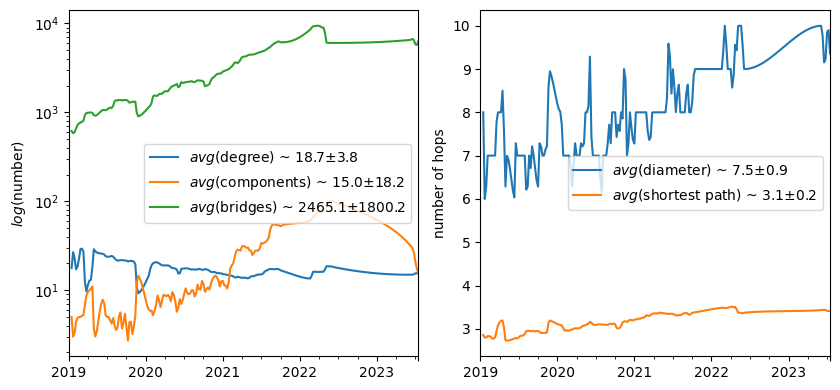

In [25]:
fig = plt.figure(figsize=(8.5, 4))

ax = fig.add_subplot(1, 2, 1)
d = mbase[['mean_degree', 'components', 'bridges']]
p = _mbase
d.plot(ax=ax)
ax.legend([f"$avg$(degree) ~ {p['mean_degree'].mean():.1f}±{p['mean_degree'].std():.1f}",
           f"$avg$(components) ~ {p['components'].mean():.1f}±{p['components'].std():.1f}",
           f"$avg$(bridges) ~ {p['bridges'].mean():.1f}±{p['bridges'].std():.1f}"],
           loc='center right')
ax.set_yscale('log')
ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
ax.set_ylabel('$log$(number)')
ax.set_xlabel(None)

ax = fig.add_subplot(1, 2, 2)
d = mbase[['max_diameter', 'path_length']]
d.plot(ax=ax)
ax.legend([f"$avg$(diameter) ~ {p['max_diameter'].mean():.1f}±{p['max_diameter'].std():.1f}",
           f"$avg$(shortest path) ~ {p['path_length'].mean():.1f}±{p['path_length'].std():.1f}"],
           loc='center right')
ax.set_xlim(left=datetime(2019, 1, 1))#, right=datetime(2023, 10, 1))
ax.set_ylabel('number of hops')
ax.set_xlabel(None)

fig.tight_layout()
fig.savefig('fig4.png', dpi=600, bbox_inches='tight')